# Лабораторная работа 4.2.1

#### Кольца Ньютона

### Библиотеки 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
import math as m
import random as r

from scipy.optimize import curve_fit
from scipy.integrate import quad

In [2]:
def Line(x, a, b):
    """
    Параметрическая прямая
    """
    return a*x + b

#-----------------------------------------------------------------------------------------------------------
#
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! ВНИМАНИЕ !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#
# Тупой питон не может подставить знак минус перед коэффициентом b! Если экспонента имеет вид e(^b), b < 0,
# то минус надо указать вручную.
#
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#
#-----------------------------------------------------------------------------------------------------------
def Exponent(x, a, b, c):
    """
    Параметрическая експонента (ae^(bx)
    """
    return a * np.exp(-b * x) + c

def CalcErrors(popt, cov, precA = 4, precB = 4, printRes = True):
    """
    Вычисляет погрешность МНК.
    Выводит в консоль значения + погрешность.
    Возвращает массив погрешностей.
    """
    errors = []
    for i in range(len(popt)):
        try:
          errors.append(np.absolute(cov[i][i])**0.5)
        except:
          errors.append( 0.00 )
    errors = np.array(errors)

    if (printRes == True):
        print("a = {:.0{prec}f} sig_a = {:.0{prec}f}".format(popt[0], errors[0], prec = precA))
        print("b = {:.0{prec}f} sig_b = {:.0{prec}f}".format(popt[1], errors[1], prec = precB), '\n')

    return errors

def NpToStrList(np_array, precision):
    np_array = np.around(np_array.astype(float), precision)

    return ["{:.0{prec}f}".format(val, prec = precision) for val in np_array]

def NpToStr(array):
    return [str(f) for f in array]

def PrintMinMax(array, header):
    print(header + "min = {:.3f}, max = {:.3f}".format(min(array), max(array)))
    
#jnb.HideCell()

In [3]:
def _getIndex(indexRow, indexColumn, isRowDataSet):
    """
    Возвращает индексы в правильном порядке для обращения к массиву.
    """
    if (isRowDataSet == True):
        return (indexRow, indexColumn)
    else:
        return (indexColumn, indexRow)

def _drawRowGrid(file, rowGrid, rowIndex):
    if (rowGrid != None and rowGrid[rowIndex] > 0):
         file.write("\\hline\n" * rowGrid[rowIndex])

def _getTableDim(data, isRowDataSet):
    if (isRowDataSet == True):
        return (len(data), len(data[0]))
    else:
        return (len(data[0]), len(data))

def _createTable(fileName, data, isRowDataSet, 
                 columnGrid = None, rowGrid = None, preheader = None):
    """
    Создаёт вертикальную Latex-таблицу, если rowDataSet == false и горизонтальную, если rowDataSet == true.

    Аргументы:
    fileName     - имя выходного файла с таблицей;
    data         - массив данных таблицы;
    isRowDataSet - если true, массив данных содержит горизонтальную таблицу, иначе вертикальную;
    columnGrid   - строка, которая определяет тип сетки между колонками: \begin{tabular}{columnGrid};
    rowGrid      - список длины rowCount + 1, в котором содержится число:
                        - 0 - нет       горизонтальной линии;
                        - 1 - одинарная горизонтальная линия;
                        - 2 - двойная   горизонтальная линия.
    """
    rowCount, columnCount = _getTableDim(data, isRowDataSet)

    with open("tables\\" + fileName, 'w', encoding='utf-8') as file:

        if (columnGrid == None):
            columnGrid = "|" + 'c|' * columnCount
        
        file.write("\\begin{tabular}[t]{" + columnGrid +"}\n")

        _drawRowGrid(file, rowGrid, 0)
        
        if (preheader != None):
            file.write(preheader)

        for rowIndex in range(0, rowCount):

            for colIndex in range(0, columnCount - 1):
                index1, index2 = _getIndex(rowIndex, colIndex, isRowDataSet)

                file.write("{} & ".format(str(data[index1][index2]).replace('.', ',')))

            index1, index2 = _getIndex(rowIndex, columnCount - 1, isRowDataSet)

            file.write("{} \\\\ \n".format(str(data[index1][index2]).replace('.', ',')))

            _drawRowGrid(file, rowGrid, rowIndex + 1)

        # End data draw cycle
        file.write('\end{tabular}')

def CreateVerticalTable(fileName, data, 
                 columnGrid = None, rowGrid = None, preheader = None):
    """
    Создаёт вертикальную Latex-таблицу.
    """
    _createTable(fileName, data, False, columnGrid = columnGrid, rowGrid = rowGrid, preheader = preheader)

def CreateVerticalTableHeader(fileName, header, dataColumns, 
                 columnGrid = None, rowGrid = None, preheader = None):
    """
    Создаёт вертикальную Latex-таблицу.
    """
    _createTable(fileName, [[header[st]] + dataColumns[st] for st in range(0, len(dataColumns))],
                                False, columnGrid = columnGrid, rowGrid = rowGrid, preheader = preheader)

def CreateHorizontalTable(fileName, dataRows, 
                 columnGrid = None, rowGrid = None, preheader = None):
    """
    Создаёт горизонтальную Latex-таблицу.
    """
    _createTable(fileName, dataRows, True, columnGrid = columnGrid, rowGrid = rowGrid, preheader = preheader)
    

In [4]:
clbr_del1 = 0.8 / 8.19 # мм / дел
_clbr_del2 = 0.1 * 3.9 / 4

eps_del1 = ((0.005 / 0.8)**2 + (0.005 / 8.19)**2)**0.5
_eps_del2 = ((0.005 / 0.39)**2 + (0.005 / 4)**2)**0.5

print(clbr_del1 * 1e3, "\t+-", eps_del1 * clbr_del1 * 1e3, "\t", eps_del1 * 100, "%")
print(_clbr_del2 * 1e3, "\t\t\t+-", _eps_del2 * _clbr_del2 * 1e3, "\t", _eps_del2 * 100, "%")

97.68009768009769 	+- 0.6134062117927952 	 0.6279746093228739 %
97.5 			+- 1.2559273528452988 	 1.2881306183028705 %


In [9]:
del_left1 = np.array([3.38, 2.85, 2.68, 2.31, 2.20, 1.96, 1.85, 1.62, 1.58, 1.33, 1.22, 1.08, 0.99, 0.84, 0.71, 0.62, 0.55, 0.41, 0.34, 0.22, 0.13])
del_right1 = np.array([4.59, 5.14, 5.42, 5.73, 5.86, 6.14, 6.27, 6.48, 6.56, 6.73, 6.82, 7.03, 7.10, 7.24, 7.32, 7.45, 7.51, 7.67, 7.73, 7.84, 7.91, 8.03, 8.10])

eps_del_left1 = (0.005 / del_left1)
eps_del_right1 = (0.005 / del_right1)

left1  = del_left1 * clbr_del1
right1 = del_right1 * clbr_del1

eps_left1 = (eps_del_left1**2 + eps_del1**2)**0.5
eps_right1 = (eps_del_right1**2 + eps_del1**2)**0.5

sig_left1 = eps_left1 * left1
sig_right1 = eps_right1 * right1

_center1 = (left1[0] + right1[0]) / 2
sig_center1 = (sig_left1[0]**2 + sig_right1[0]**2)**0.5 / 2

r_light1 = []
r_dark1  = []
sig_light1 = []
sig_dark1 = []

print("light")
_st = 1
for st1 in range(1, min(len(left1), len(right1)), 2):
    r_light_left = _center1 - (left1[st1 - 1] + left1[st1]) / 2
    r_light_right = (right1[st1 - 1] + right1[st1]) / 2 - _center1
    r_light = (r_light_left + r_light_right) / 2
    r_light1.append(r_light)

    sig_r_light_left = (sig_center1**2 + sig_left1[st1 - 1]**2 / 4 + sig_left1[st1]**2 / 4)**0.5
    sig_r_light_right = (sig_center1**2 + sig_right1[st1 - 1]**2 / 4 + sig_right1[st1]**2 / 4)**0.5
    sig_light = (sig_r_light_left**2 + sig_r_light_right**2)**0.5 / 2
    sig_light1.append(sig_light)

    print("# {:2} l = {:3.0f} r = {:3.0f} all = {:3.0f} +- {:3.0f}".format(
        _st, r_light_left * 1000, r_light_right * 1000, r_light * 1000, sig_light * 1e3))

    _st += 1

print("\ndark")
_st = 1
for st1 in range(2, min(len(left1), len(right1)), 2):
    r_dark_left = _center1 - (left1[st1 - 1] + left1[st1]) / 2
    r_dark_right = (right1[st1 - 1] + right1[st1]) / 2 - _center1
    r_dark = (r_dark_left + r_dark_right) / 2
    r_dark1.append(r_dark)

    sig_r_dark_left = (sig_center1**2 + sig_left1[st1 - 1]**2 / 4 + sig_left1[st1]**2 / 4)**0.5
    sig_r_dark_right = (sig_center1**2 + sig_right1[st1 - 1]**2 / 4 + sig_right1[st1]**2 / 4)**0.5
    sig_dark = (sig_r_dark_left**2 + sig_r_dark_right**2)**0.5 / 2
    sig_dark1.append(sig_dark)

    print("# {:2} l = {:3.0f} r = {:3.0f} all = {:3.0f} +- {:3.0f}".format(
        _st, r_dark_left * 1000, r_dark_right * 1000, r_dark * 1000, sig_dark * 1e3))

    _st += 1

r_light1 = np.array(r_light1)
r_dark1 = np.array(r_dark1)
sig_light1 = np.array(sig_light1)
sig_dark1 = np.array(sig_dark1)

r_light1_sq = r_light1 * r_light1
r_dark1_sq = r_dark1 * r_dark1

eps_r_light1_sq = 2 * sig_light1 / r_light1
eps_r_dark1_sq = 2 * sig_dark1 / r_dark1
sig_r_light1_sq = eps_r_light1_sq * r_light1_sq
sig_r_dark1_sq = eps_r_dark1_sq * r_dark1_sq

m_1 = np.array(list(range(1, 11)))

light
#  1 l =  85 r =  86 all =  85 +-   2
#  2 l = 146 r = 155 all = 150 +-   2
#  3 l = 186 r = 197 all = 191 +-   2
#  4 l = 220 r = 233 all = 227 +-   2
#  5 l = 247 r = 260 all = 253 +-   2
#  6 l = 277 r = 287 all = 282 +-   2
#  7 l = 300 r = 311 all = 305 +-   2
#  8 l = 324 r = 332 all = 328 +-   2
#  9 l = 342 r = 352 all = 347 +-   2
# 10 l = 362 r = 371 all = 367 +-   2

dark
#  1 l = 119 r = 126 all = 123 +-   2
#  2 l = 169 r = 177 all = 173 +-   2
#  3 l = 203 r = 217 all = 210 +-   2
#  4 l = 233 r = 248 all = 240 +-   2
#  5 l = 265 r = 273 all = 269 +-   2
#  6 l = 288 r = 301 all = 295 +-   2
#  7 l = 314 r = 322 all = 318 +-   2
#  8 l = 332 r = 341 all = 337 +-   2
#  9 l = 353 r = 363 all = 358 +-   2
# 10 l = 372 r = 380 all = 376 +-   2


In [11]:
pl1, cl1 = curve_fit(Line, m_1, r_light1_sq)
pd1, cd1 = curve_fit(Line, m_1, r_dark1_sq)

errl1 = CalcErrors(pl1, cl1)
errd1 = CalcErrors(pd1, cd1)

lambda_yellow = 578,2 * 1e-9 * 1e3
lambda_green  = 546.1 * 1e-9 * 1e3

R1 = pl1[0] / lambda_green
R2 = pd1[0] / lambda_green

eps_R1 = errl1[0] / pl1[0]
eps_R2 = errd1[0] / pd1[0]

sig_R1 = eps_R1 * R1
sig_R2 = eps_R2 * R2

print("R1 = {:} +- {:}".format(R1, sig_R1))
print("R2 = {:} +- {:}".format(R2, sig_R2))

a = 0.0141 sig_a = 0.0001
b = -0.0057 sig_b = 0.0005 

a = 0.0140 sig_a = 0.0001
b = 0.0018 sig_b = 0.0004 

R1 = 25.81031417149319 +- 0.14389236765610613
R2 = 25.68482427605301 +- 0.1226403283924516


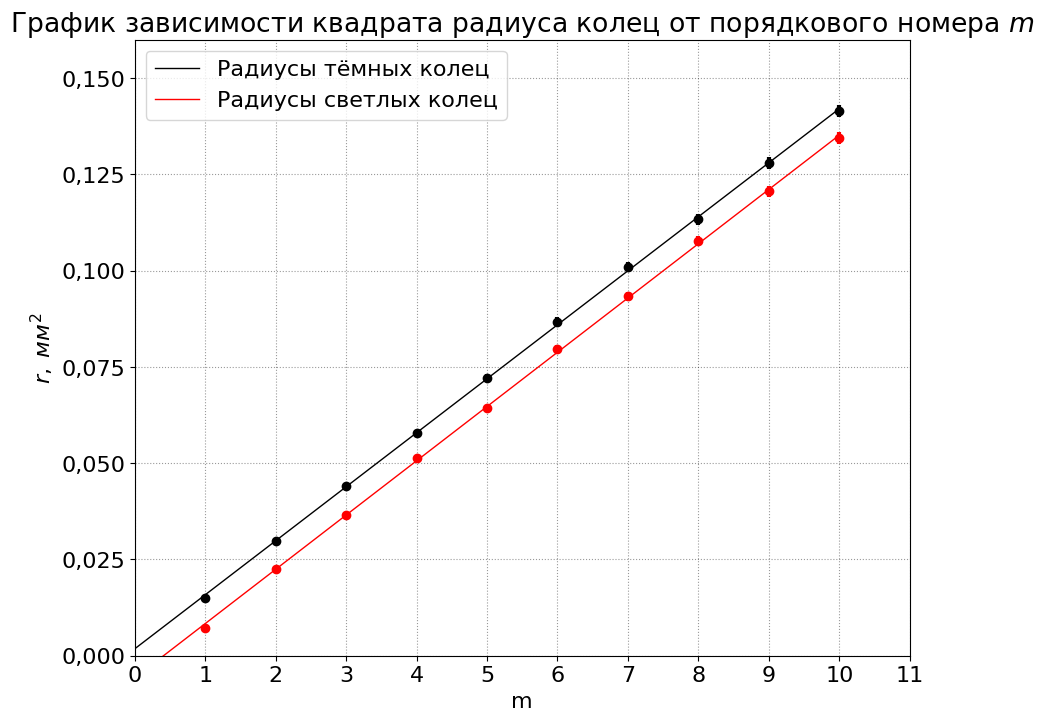

In [10]:
xMin = 0
xMax = 11.001

yMin = 0
yMax = 160.001e-3

plotTitle       = 'График зависимости квадрата радиуса колец от порядкового номера $m$'

xLabel          = r'm'
yLabel          = r'$r, \; мм^2$'

xMinorStep      = 0
xMajorStep      = 1

yMinorStep      = 0
yMajorStep      = 25e-3

xTickMultiplier = 1
yTickMultiplier = 1

xPrecision      = 0
yPrecision      = 3

# Построение графика.

mpl.rcParams['font.size'] = 16

fig  = plt.figure(figsize = (10,8), dpi = 100)
axes = fig.add_subplot()

fig.set_facecolor("white")

# Заголовок

plt.title(plotTitle)
plt.xlabel(xLabel)
plt.ylabel(yLabel)

# Линии

x = np.array([xMin, xMax])

plt.errorbar(m_1, r_dark1_sq, yerr = sig_r_dark1_sq, xerr = 0, fmt = 'o', linewidth = 3, color = 'black')
plt.errorbar(m_1, r_light1_sq, yerr = sig_r_light1_sq, xerr = 0, fmt = 'o', linewidth = 3, color = 'red')

_m_1 = np.array(list(range(0, 11)))
plt.plot(_m_1, Line(_m_1, *pd1), linewidth = 1, color = 'black', label = "Радиусы тёмных колец")
plt.plot(_m_1, Line(_m_1, *pl1), linewidth = 1, color = 'red', label = "Радиусы светлых колец")

# Оформление масштабных чёрточек

if yMajorStep > 0:
    y_major_ticks = np.arange(yMin, yMax, yMajorStep)
    axes.set_yticks(y_major_ticks)

if yMinorStep > 0:
    y_minor_ticks = np.arange(yMin, yMax, yMinorStep)
    axes.set_yticks(y_minor_ticks, minor = True)

if xMajorStep > 0:
    x_major_ticks = np.arange(xMin, xMax, xMajorStep)
    axes.set_xticks(x_major_ticks)

if xMinorStep > 0:
    x_minor_ticks = np.arange(xMin, xMax, xMinorStep)
    axes.set_xticks(x_minor_ticks, minor = True)

# Пределы графика

plt.xlim([xMin, xMax])
plt.ylim([yMin, yMax])

# Форматирование чёрточек

def xTickFormatter(tickVal, position):
    return "{:.{prec}f}".format(tickVal * xTickMultiplier, prec = xPrecision).replace('.', ',')

def yTickFormatter(tickVal, position):
    return "{:.{prec}f}".format(tickVal * yTickMultiplier, prec = yPrecision).replace('.', ',')

axes.xaxis.set_major_formatter(ticker.FuncFormatter(xTickFormatter))
axes.yaxis.set_major_formatter(ticker.FuncFormatter(yTickFormatter))

# Легенда
plt.legend(loc = 'upper left')

# Сетка
plt.grid(which='major', linestyle = ':', c = 'black', alpha = 0.4)
plt.grid(which='minor', linestyle = ':', c = 'black', alpha = 0.1)

# Вывод
plt.savefig("Графики/Радиус линзы.png")
plt.show()